FiPy implementation of problem 2.3: "Explicit nucleation, multiple seeds at random times"

in *Benchmark problems for nucleation*, Tamás Pusztai, September 25, 2019

In [1]:
import os
import re
import sys
import time
import yaml

import datreant.core as dtr

import fipy as fp
from fipy.tools import parallelComm
from fipy.meshes.factoryMeshes import _dnl

from fipy.tools.debug import PRINT

Load parameters

In [2]:
from IPython import get_ipython
if get_ipython() is None:
    yamlfile = sys.argv[1]
else:
    yamlfile = "params8c.yaml"

with open(yamlfile, 'r') as f:
    params = yaml.load(f)

Set any parameters for interactive notebook

In [3]:
if get_ipython() is not None:
    params['Lx'] = 100.
    params['Ly'] = 100.
    params['checkpoint'] = 1.5 * params['dt']
    params['savetime'] = 4 * params['dt'] 
    params['totaltime'] = 100 * params['dt']
    params['restart'] = "t=1.830842598338903.tar.gz"

Setup ouput storage

In [4]:
try:
    from sumatra.projects import load_project
    project = load_project(os.getcwd())
    record = project.get_record(params["sumatra_label"])
    output = record.datastore.root
except:
    # either there's no sumatra, no sumatra project, or no sumatra_label
    # this will be the case if this script is run directly
    output = os.getcwd()
    
if parallelComm.procID == 0:
    print "storing results in {0}".format(output)
    data = dtr.Treant(output)
else:
    class dummyTreant(object):
        categories = dict()

    data = dummyTreant()

storing results in /Users/guyer/Documents/research/CHiMaD/phase_field/phasefieldbenchmark-8


Initialize mesh and solution variables

Either restart from some `path/to/t={time}.tar.gz`, where the time is assigned to `elapsed`

or

Create a mesh based on parameters.

In [5]:
checkpoint = params['checkpoint']
savetime = params['savetime']
totaltime = params['totaltime']
dt = params['dt']

if params['restart']:
    phi, = fp.tools.dump.read(filename=params['restart'])
    mesh = phi.mesh

    Lx = max(mesh.x) - min(mesh.x)
    Ly = max(mesh.y) - min(mesh.y)

    # scanf("%g") simulator
    # https://docs.python.org/3/library/re.html#simulating-scanf
    scanf_g = "[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?"
    pattern = ".*t=({g})\.tar\.gz".format(g=scanf_g)
    elapsed = re.match(pattern, params['restart']).group(1)
    elapsed = fp.Variable(name="$t$", value=float(elapsed))
else:
    Lx = params['Lx']
    Ly = params['Ly']

    dx, nx = _dnl(dx=params['dx'], nx=None, Lx=Lx)
    dy, ny = _dnl(dx=params['dx'], nx=None, Lx=Ly)

    mesh = fp.Grid2D(dx=dx, nx=nx, dy=dy, ny=ny)

    phi = fp.CellVariable(mesh=mesh, name="$\phi$", value=0., hasOld=True)

    elapsed = fp.Variable(name="$t$", value=0.)
    
x, y = mesh.cellCenters[0], mesh.cellCenters[1]
X, Y = mesh.faceCenters[0], mesh.faceCenters[1]

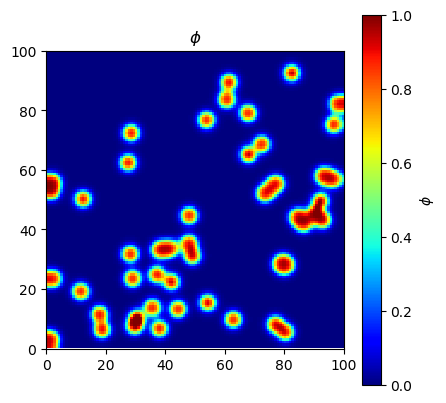

In [6]:
if get_ipython() is not None:
    viewer = fp.Viewer(vars=phi, datamin=0., datamax=1.)
    viewer.plot()

Given driving force $\Delta f = 1 / (6\sqrt{2})$

In [7]:
Delta_f = 1. / (6 * fp.numerix.sqrt(2.))

define governing equation 
\begin{align}
\frac{\partial\phi}{\partial t} &= \nabla^2\phi - g'(\phi) + \Delta f p'(\phi) \tag{7}
\end{align}
$$g(\phi) = \phi^2(1 - \phi)^2 \qquad p(\phi)=\phi^3(10 - 15\phi + 6\phi^2)$$
following [`examples/phase/simple.py`](https://www.ctcms.nist.gov/fipy/examples/phase/generated/examples.phase.simple.html)


\begin{align}
\frac{\partial\phi}{\partial t}
&= \nabla^2\phi + m_\phi \phi (1 - \phi) \notag
\qquad\text{for $m_\phi \equiv -2(1 - 2\phi) + 30 \phi (1 - \phi) \Delta f$} \notag
\\
&= \nabla^2\phi + S \notag
\\
&= \nabla^2\phi + S|_\text{old} 
+ \left.{\frac{\partial S}{\partial \phi}}\right|_\text{old} (\phi - \phi_\text{old}) 
\notag \\
&= \nabla^2\phi + \left(S - \frac{\partial S}{\partial \phi} \phi\right)_\text{old} 
- \left.{\frac{\partial S}{\partial \phi}}\right|_\text{old} \phi \notag
\\
&= \nabla^2\phi + S_0 + S_1 \phi \notag
\\
S_0 &\equiv \left(S - \frac{\partial S}{\partial \phi} \phi\right)_\text{old}
\notag \\
&= m_\phi \phi_\text{old} (1 - \phi_\text{old}) - S_1 \phi_\text{old}
\notag \\
S_1 &\equiv \left.{\frac{\partial S}{\partial \phi}}\right|_\text{old}
\notag \\
&= \frac{\partial m_\phi}{\partial \phi} \phi (1 - \phi) + m_\phi (1 - 2\phi)
\notag
\end{align}

In [8]:
mPhi = -2 * (1 - 2 * phi) + 30 * phi * (1 - phi) * Delta_f
dmPhidPhi = 4 + 30 * (1 - 2 * phi) * Delta_f
S1 = dmPhidPhi * phi * (1 - phi) + mPhi * (1 - 2 * phi)
S0 = mPhi * phi * (1 - phi) - S1 * phi

eq = (fp.TransientTerm() == 
      fp.DiffusionTerm(coeff=1.) + S0 + fp.ImplicitSourceTerm(coeff=S1))

Total free energy
\begin{align}
F[\phi] = \int\left[\frac{1}{2}(\nabla\phi)^2 + g(\phi) - \Delta f p(\phi)\right]\,dV \tag{6}
\end{align}

In [9]:
ftot = (0.5 * phi.grad.mag**2
        + phi**2 * (1 - phi)**2
        - Delta_f * phi**3 * (10 - 15 * phi + 6 * phi**2))
volumes = fp.CellVariable(mesh=mesh, value=mesh.cellVolumes)
F = ftot.cellVolumeAverage * volumes.sum()

Output results

In [10]:
def saveStats(elapsed):
    stats = "{}\t{}\t{}\n".format(elapsed.value, phi.cellVolumeAverage.value, F.value)
    if parallelComm.procID == 0:
        with open(data['stats.txt'].make().abspath, 'a') as f:
            f.write(stats)

def savePhi(elapsed):
    if parallelComm.procID == 0:
        fname = data["t={}.tar.gz".format(elapsed)].make().abspath
    else:
        fname = None
    fname = parallelComm.bcast(fname)

    fp.tools.dump.write((phi,), filename=fname)

if parallelComm.procID == 0:
    with open(data['stats.txt'].make().abspath, 'a') as f:
        f.write("\t".join(["time", "fraction", "energy"]) + "\n")

saveStats(elapsed)
savePhi(elapsed)

"generate ... supercritical seeds with $r_0 = 1.1r^∗$. ... When adding a new seed, simply add the $\phi$ values given by the $\phi(r)$ profile
\begin{align}
\phi(x) &= \frac{1 - \tanh\left(\frac{x - x_0}{\sqrt{2}}\right)}{2}\tag{8}
\end{align}
to the $\phi$ values already in the domain, and handle the possible overlaps by setting $\phi = 1$ for all cells where $\phi > 1.$"

In [11]:
def nucleus(x0, y0, r0):
    r = fp.numerix.sqrt((x - x0)**2 + (y - y0)**2)

    return (1 - fp.numerix.tanh((r - r0) / fp.numerix.sqrt(2.))) / 2

Either load nucleation times from `path/to/restart/nucleation_times.txt`, based on directory of `params['restart']`

or

"generate 100 random nucleation times in the range $t=0\dots100$ for adding the 100 seeds to the simulation domain."

In [12]:
if params['restart']:
    fname = os.path.join(os.path.dirname(params['restart']), 
                         "nucleation_times.txt")
    nucleation_times = fp.numerix.loadtxt(fname)
else:
    nucleation_times = fp.numerix.random.random(params['numnuclei']) * totaltime
    nucleation_times.sort()
    fp.numerix.savetxt(data['nucleation_times.txt'].make().abspath, nucleation_times)
nucleation_times = nucleation_times[nucleation_times > elapsed]

Figure out when to save

In [13]:
checkpoints = (fp.numerix.arange(int(elapsed / checkpoint), int(totaltime / checkpoint)) + 1) * checkpoint
for sometime in [savetime, totaltime]:
    if sometime > elapsed and sometime not in checkpoints: 
        checkpoints = fp.tools.concatenate([checkpoints, [sometime]])
checkpoints = fp.tools.concatenate([checkpoints, nucleation_times])
checkpoints.sort()

Solve loop

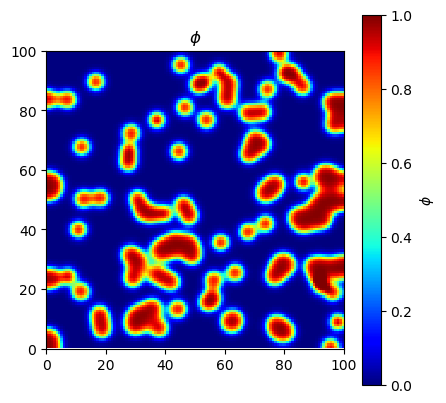

<Figure size 432x288 with 0 Axes>

In [14]:
for until in checkpoints:
    while elapsed.value < until:
        phi.updateOld()
        dt_until = (until - elapsed).value
        dt_save = dt
        if dt_until < dt:
            dt = dt_until
        for sweep in range(5):
            eq.sweep(var=phi, dt=dt)
        elapsed.value = elapsed() + dt
        saveStats(elapsed)
        dt = dt_save

    if elapsed in nucleation_times:
        fx, fy = fp.numerix.random.random(size=(2,))
        phi.setValue(phi + nucleus(x0=fx * Lx, y0=fy * Ly, r0=params['factor'] * 2))
        phi.setValue(1., where=phi > 1.)

    savePhi(elapsed)

    if get_ipython() is not None:
        viewer.plot()